# **PROYECTO FINAL  - DATA SCIENCE - CODERHOUSE**
 PRIMER ENTREGA



# **PROYECTO FINAL  - DATA SCIENCE - CODERHOUSE**
 PRIMER ENTREGA




## **Objetivos de la Invetigacion:** 
**Objetivo principal:** Analisis de Sentimiento sobre Reviews de Videojuegos con aplicación simple de NLP.

**Objetivo secundario**: Analisis exploratorio de las variables secundarias para conocer su relacion con respecto a la variable target.



**Conformacion del equipo de trabajo:**
*   Gerardo Heidel<br>
*   Francisco Lopez Ballent<br>
*   Ignacio Manuel Vallecillo<br>

# **Data Adquisition**

**Informacion del Dataset:**

  Seleccionamos dos dataset con la siguientes caracteristicas:
1.   Steam Reviews


*   **Contenido Original:** 6.4 Millones de Reviews en Ingles de diferentes juegos publicados en la plataforma Steam de Valve.

*   **Fuente:** Kaggle

*  **URL:** https://www.kaggle.com/datasets/andrewmvd/steam-reviews


2.   Steam Store Games
*   **Contenido Original:** Data combinada de mas de 27.000 juegos scrapeados de la plataforma Steam y de SteamSpy APIs.

*   **Fuente:** Kaggle

*  **URL:** https://www.kaggle.com/datasets/nikdavis/steam-store-games

## Aclaraciones sobre la conformacion del Dataset

Debido a la inmensidad del Dataset Orignal de las Steam Reviews, se decidio tomar un 3,125% del mismo (Cuyo contenido se obtuvo de forma aleatoria) como dataset a utilizar para la investigacion. Al mismo, decidimos integrarle informacion adicional de cada uno de los juegos al que pertenecen las reviews. Para ello, mergeamos la información del dataset Steam Store Games que creemos pertinente para la investigacion.

## Importacion de librerias y lectura de Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Generales
import pandas as pd
import numpy as np
import re
import random
#Visualizacion
import cudf, cupy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
#Machine Learning
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
import spacy
#Otros
import warnings
warnings.filterwarnings('ignore')

Cambio de estilo de graficas

In [3]:
mpl.style.use('dark_background')
mpl.rcParams.update({'font.size': 12})

In [4]:
df_data_steam = cudf.read_csv('steam.csv')
df_data_steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [5]:
# Nacho
#df_reviews = pd.read_csv('/content/drive/MyDrive/Coderhouse-DataScience2022/Proyecto_Final_DS/Datasets/reviews_full.csv')
# Fran
df_reviews = cudf.read_csv('reviews_full.csv')
df_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


Seleccionamos de manera aleatoria 100K reviews positivas y 100K negativas para balancear el dataset

In [6]:
df_pos = df_reviews[df_reviews.review_score == 1].sample(100000, random_state=10)
df_neg = df_reviews[df_reviews.review_score == -1].sample(100000, random_state=10)
df_reviews = cudf.concat([df_pos, df_neg])

Merge de data de Reviews y data de Games para formar el dataset que vamos a usar

In [7]:
df = df_reviews.merge(right=df_data_steam.rename(columns={'appid':'app_id'}), how='inner',on='app_id')
df.head()

,app_id,app_name,review_text,review_score,review_votes,name,release_date,english,developer,publisher,...,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,34030,Total War: NAPOLEON - Definitive Edition,Love this game it is so much fun!,1,0,Total War: NAPOLEON – Definitive Edition,2010-02-25,1,CREATIVE ASSEMBLY;Feral Interactive (Mac),SEGA;Feral Interactive (Mac),...,Single-player;Multi-player;Steam Achievements;...,Strategy,Strategy;Historical;Grand Strategy,71,8540,907,1251,1534,2000000-5000000,0.00
1,220240,Far Cry® 3,"Excellent game in many regards, and I haven't ...",1,0,Far Cry 3,2012-11-28,1,"Ubisoft Montreal, Massive Entertainment, and U...",Ubisoft,...,Single-player;Multi-player;Co-op;Partial Contr...,Action;Adventure,Open World;FPS;Action,0,46331,5622,836,794,2000000-5000000,16.99
2,4720,Condemned: Criminal Origins,"Had high expectations, it's well regarded by m...",1,0,Condemned: Criminal Origins,2012-10-29,1,Monolith,SEGA,...,Single-player,Action,Horror;Action;Atmospheric,0,1243,221,312,312,200000-500000,9.99
3,8190,Just Cause 2,Awesome game! You can spend so many hours just...,1,0,Just Cause 2,2010-03-23,1,Avalanche Studios,Square Enix,...,Single-player;Steam Achievements;Full controll...,Action;Adventure,Open World;Action;Sandbox,50,33636,3231,519,272,2000000-5000000,9.99
4,403190,Planetbase,"I do like this game, but it can be really frus...",1,0,Planetbase,2015-10-15,1,Madruga Works,Madruga Works,...,Single-player;Steam Achievements;Steam Trading...,Indie;Simulation;Strategy,City Builder;Base-Building;Space,30,4171,1267,1069,1346,200000-500000,15.49


## Descripcion del dataset

**Diccionario de Parámetros**

*   **app_id:** ID unico para cada titulo.
*   **app_name:** Nombre del juego.
*   **review_text:** Contenido de la review.
*  **review_score:** Valoracion de la review (1 -> Positiva / 0 -> Negativa).
*  **review_votes:** Valoracion de otros usuarios a la review (1 -> Tiene valoraciones positivas / 0 -> No tiene valoraciones positivas).
* **release_date:** Formato Año-Mes-Dia.
* **english:** Si el idioma es Ingles o no / 1 = True, 0 = False .
* **developer:** Empresa o persona que desarrollo  el juego.
* **publisher:** Nombre o nombres de los Publicantes. Se usa un (;) para delimitar si son multiples.
* **platforms:** Lista de Sist Op soportados delimitada por (;)
* **required_age:** Mínimo de edad requerida segun PEGI UK standards. Figura (0) para aquellos no clasificados o no suministrados. 
* **categories:** Lista de categorias de juegos delimitada por (;)
* **genres:** Lista de géneros de juegos delimitada por (;)
* **steamspy_tags:** Lista de los top steamspy game tags, que son similares a los generos pero votados por la comunidad gamer.
* **achievements:** Número de logros in-game sí hay.
* **positive_ratings:** Cantidad de valoraciones positivas del juego segun SteamSpy.
* **negative_ratings:** Cantidad de valoraciones negativas del juego segun SteamSpy.
* **average_playtime:** Promedio de tiempo de juego segun SteamSpy.
* **median_playtime:** Mediana de tiempo de juego segun SteamSpy.
* **owners:** Rango estimado de propietarios del juego. Contiene el limite Inferior y Superior.
* **price:** Precio actualizado del juego en GBP (Libras Esterlinas)






Limpieza de columnas que no vamos a usar como **'name'**, ya que hace referencia al nombre del juego que ya esta contemplado en **'app_name'**.

In [8]:
df = df.drop(columns=['name', 'steamspy_tags', 'achievements', 'english'])

Tipo de dato de cada columna

In [9]:
df.dtypes

app_id                int64
app_name             object
review_text          object
review_score          int64
review_votes          int64
release_date         object
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

Shape

In [10]:
print(f'El dataset tiene:\n -> {df.shape[0]} filas\n -> {df.shape[1]} columnas') 

El dataset tiene:
 -> 180080 filas
 -> 18 columnas


Cantidad de juegos

In [11]:
print(f' -> {df.app_name.nunique()} juegos') 

 -> 6410 juegos


Cantidad de missing values en porcentaje

In [12]:
df.isna().sum()/df.shape[0]*100

app_id              0.000000
app_name            1.479343
review_text         0.098845
review_score        0.000000
review_votes        0.000000
release_date        0.000000
developer           0.000000
publisher           0.000000
platforms           0.000000
required_age        0.000000
categories          0.000000
genres              0.000000
positive_ratings    0.000000
negative_ratings    0.000000
average_playtime    0.000000
median_playtime     0.000000
owners              0.000000
price               0.000000
dtype: float64

## Preprocesamiento de los Datos

Eliminamos aquellos valores que tienen missing values en "review_text" y chequeamos que el dataset siga balanceado

In [13]:
df = df.dropna(subset=['review_text'])
df_aux = df.review_score.value_counts(normalize=True)
print(f'Reviews positivas (1) -> {df_aux.iloc[0].round(2)*100}%\nReviews negativas (-1) -> {df_aux.iloc[1].round(2)*100}%')

Reviews positivas (1) -> 50.999999046325684%
Reviews negativas (-1) -> 49.000000953674316%


###Preprocesamiento del texto



Veamos algunos valores random para saber con que nos encontramos

In [14]:
random.seed(6)
random_idx_list = [random.randint(1,len(df.review_text)) for i in range(15)] 
random_rev_text = [df.loc[random_idx_list].review_text.head(15).iloc[i] for i in range(15)]
for i, rev in zip(range(15), random_rev_text):
  print(f'{i} -> {rev}\n')

0 -> Wanna get ♥♥♥♥ed over by the devs? Want to pay REAL money to get paint on your virtual weapon? Wanna pay REAL money to actually get your virtual weapon?? Wanna feel cockblocked after you worked hard on your LUA mod just so the devs can crush your unpaid work for the community to enjoy??? Now introducing... USELESS STUPID MICROTRANSACTIONS!!!! AS IF 50 ♥♥♥♥ING DLC'S WEREN'T ENOUGH, NOW YOU CAN TRY TO FILL OVERKILL'S HUNGER FOR MONEY! PAYDAY 2 IS JUST FOR YOU, TO ROB DIGITAL MONEY WHILE THEY ROB YOUR REAL MONEY!!!  I used to love this game and their devs. I got the game a while back, around the start of 2014, I couldn't play it cause I had a ♥♥♥♥♥♥ computer. I started playing it and I LOVED IT. Now they've added microtransaction ♥♥♥♥ and they still haven't ♥♥♥♥ing fixed their netcode or tried to optimize their game at all. DLC'S were ok, understandable, but microtransactions? REALLY? ♥♥♥♥ you. Community is VERY upset, Overkill. VERY, ♥♥♥♥ing upset, you should do as Bethesda and pull

Vemos que steam sensura malas palabras con corazones como en la (8), y tambien observamos que "Early Access Review" es una frase que se repite bastante. Por ahora lo de los corazones lo vamos a dejar asi pero veamos que porcentaje de reviews tenemos con la frase "Early Access Review".

In [15]:
round(df[df['review_text'].str.contains("Early Access Review")].review_text.count()/df.shape[0]*100, 2)

17.44

Veamos si esta frase tiene una tendencia a ser calificada como positiva o negativa.

In [16]:
df_ear = df[df['review_text'].str.contains("Early Access Review")]
df_ear
perc_pos = df.loc[df['review_score'] == 1].review_score.count()/df_ear.shape[0]*100
perc_neg = df.loc[df['review_score'] == -1].review_score.count()/df_ear.shape[0]*100
#print(f'% Positivas -> {round(perc_pos, 2)}\n% Negativas -> {round(perc_neg, 2)}')

No se observa una tendencia a que las reviews con "Early Access Review" sean evaluadas como positivas o negativas. Por lo tanto no nos aportan informacion y podemos eliminarlas.

In [17]:
df = df.drop(df[df['review_text'].str.contains("Early Access Review")].index)

Hagamos ahora una limpieza de:
*   **Stopwords**: Palabras usadas comunmente en cualquier idioma, por ejemplo en ingles "i", "who", "it", etc.  
*   **Hyperlinks**: Eliminamos todos los links como 'https://youtube.com...' que no aportan al objetivo <br>




A su vez realizamos un Stemming de las palabras. 

In [18]:
stemmer = SnowballStemmer('english')
text_cleaning_re = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [19]:
def preprocess(text):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in ENGLISH_STOP_WORDS:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [20]:
df.review_text = df.review_text.to_pandas().apply(lambda x: preprocess(x))

Analizamos cuales son las palabras mas usadas en las reviews 

In [21]:
def wcloud(w_input, tag=''):
  reviews = " ".join(w_input)
  word_cloud = WordCloud(max_words = 2000, background_color='black', width=800, height=400).generate(reviews)
  plt.rcParams["figure.figsize"] = (12, 8)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Palabras mas usadas en las Reviews {tag}',fontweight='bold')
  return

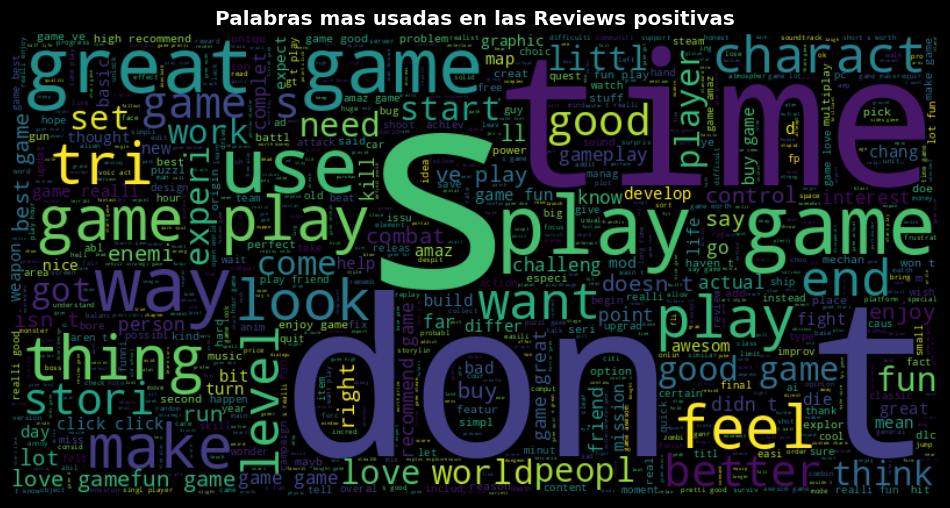

In [22]:
wcloud_pos = wcloud(df[df.review_score == 1].review_text.to_arrow().to_pylist(), 'positivas')

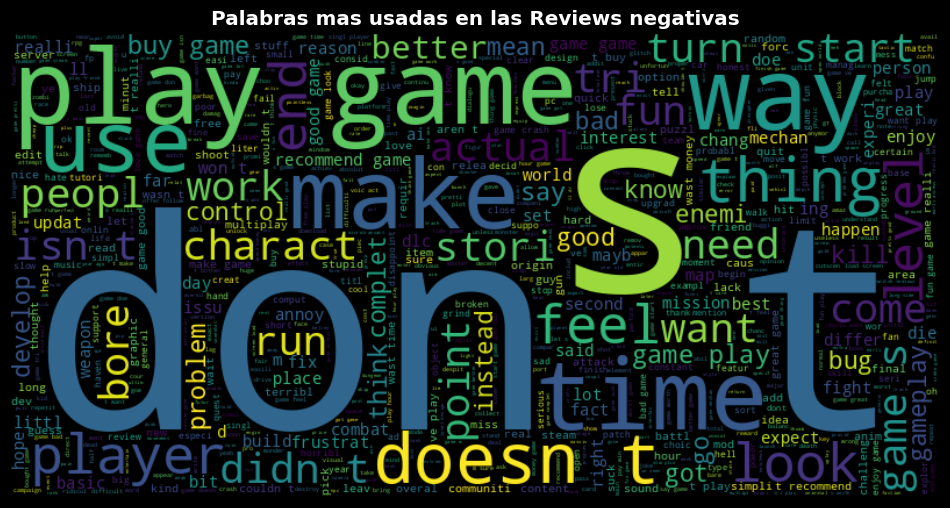

In [23]:
wcloud_neg = wcloud(df[df.review_score == -1].review_text.to_arrow().to_pylist(), 'negativas')

**Tokenizacion**<br>
Armamos un nuevo df donde transformamos a las reviews en vectores numericos para mejorar el analisis. Este df tiene como columnas todas las palabras que se utilizan en las reviews y como filas las reviews con la cantidad de veces que aparece cada palabra en la review

In [24]:
#Cuando tengamos mas RAM esto hay que correrlo sin max_features
full_list_reviews = df.review_text.to_arrow().to_pylist()
pattern = '[a-zA-z]+'
vect = CountVectorizer(token_pattern=pattern, ngram_range=(1, 2), max_features=1000)
vect.fit(full_list_reviews)
tokenized_features = vect.transform(full_list_reviews)
features_vect = cudf.DataFrame(data=tokenized_features.toarray(), columns=vect.get_feature_names_out())
features_vect.head()


,abil,abl,absolut,access,account,achiev,act,action,activ,actual,...,write,wrong,x,xbox,yeah,year,yes,youtub,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Agregamos columnas del dataset original que nos van a ser utiles para el analisis

In [25]:
features_vect = features_vect.join(cudf.DataFrame({'_score': df.review_score, 
                                                 '_votes': df.review_votes, 
                                                 '_genre': df.genres, 
                                                 '_price': df.price,
                                                 '_word_count': df.review_text.str.count(pattern),
                                                 '_avg_word_length': df.review_text.str.count(r"\S")/df.review_text.str.count(pattern)}, 
                                                index=features_vect.index))

**Word emdedding**<br>
Analisis de las palabras en su contexto

NO FUNCIONA. SE NECESITA MAS RAM PARA CORRERLO

In [26]:
#reviews = " ".join(df.review_text)

In [27]:
#nlp = spacy.load('en_core_web_sm')
#doc = nlp(reviews)

In [28]:
#tokens = reviews.split()

In [29]:
#def vec(s):
#    return nlp(s).vector

In [30]:
#from numpy import dot
#from numpy.linalg import norm

#def cosine(v1, v2):
#    if norm(v1) > 0 and norm(v2) > 0:
#        return dot(v1, v2) / (norm(v1) * norm(v2))
#    else:
#        return 0.0

In [31]:
#def spacy_closest(token_list, vec_to_check, n=10):
#    return sorted(token_list,
#                  key=lambda x: cosine(vec_to_check, vec(x)),
#                  reverse=True)[:n]

In [32]:
#spacy_closest(tokens, vec("like"))

## **Analisis exploratorio de los datos (EDA)**

###**Analisis de variables principales**

En esta seccion vamos a analizar la variable dependiente (review_text) y la variable target (review_score)

**review_text**<br>


**Distribucion de cantidad de palabras por review**


Text(0.5, 1.0, 'Distribucion de cantidad de palabras por review')

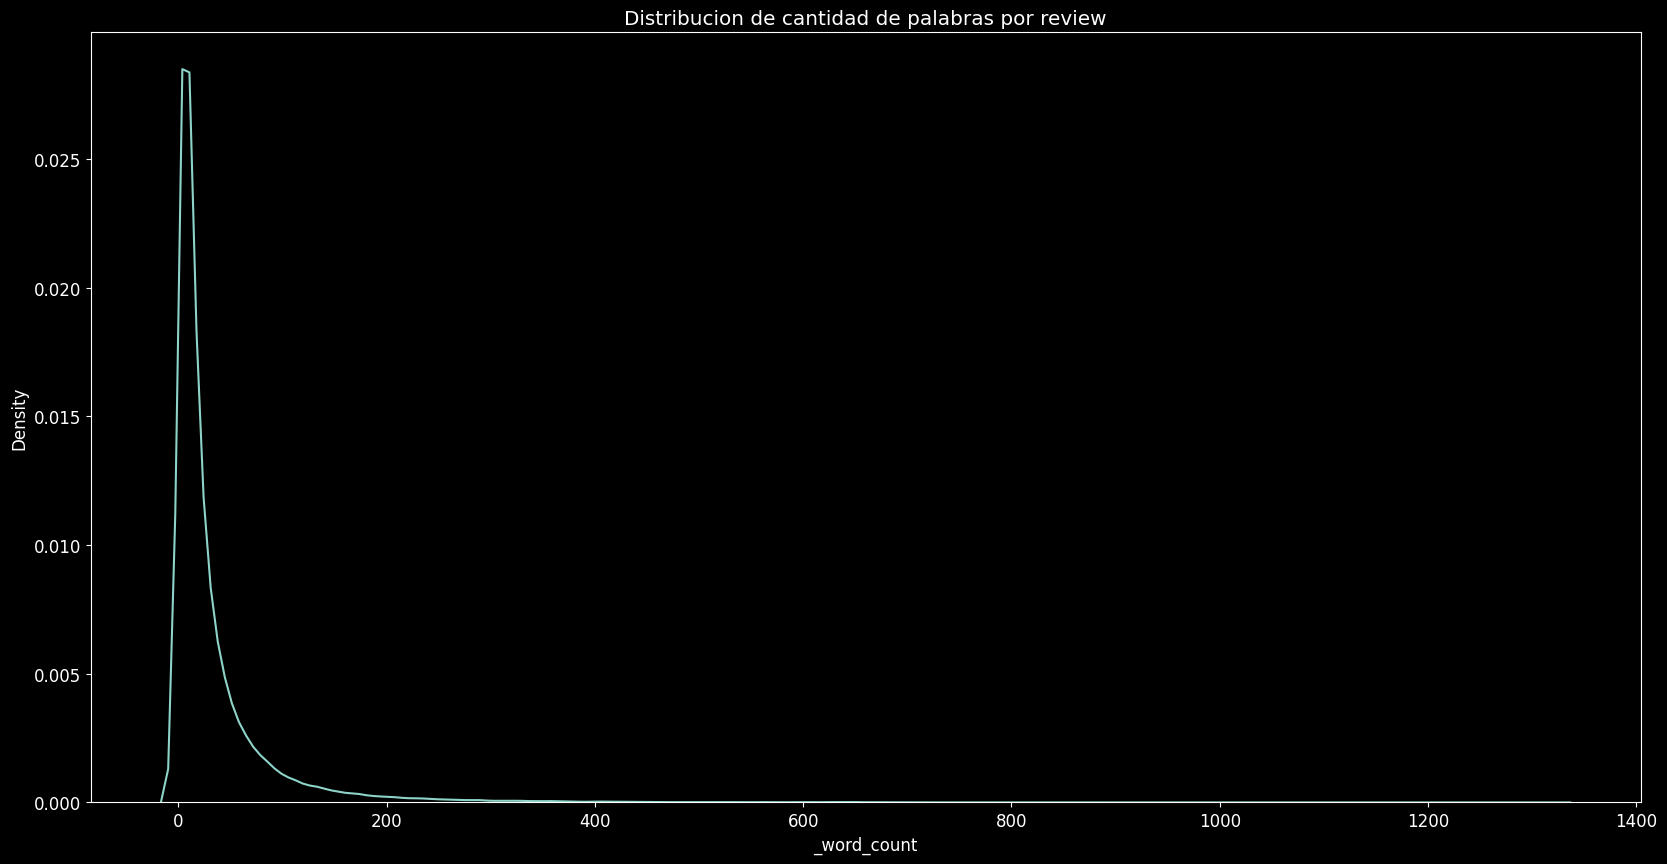

In [33]:
plt.figure(figsize=(20, 10))

feature_vect_pd = features_vect['_word_count'].to_pandas()
sns.distplot(a=feature_vect_pd, hist=False)
plt.title('Distribucion de cantidad de palabras por review')

>**Conclusión:** Podemos ver que principalmente tenemos comentarios de no mas de 50 palabras. Se puede observar una asimetria positiva dada por tener algunos comentarios con una cantidad de palabras considerable. 

**Distribucion de longitud promedio de palabras por review**

Text(0.5, 1.0, 'Distribucion de longitud promedio de palabras por review')

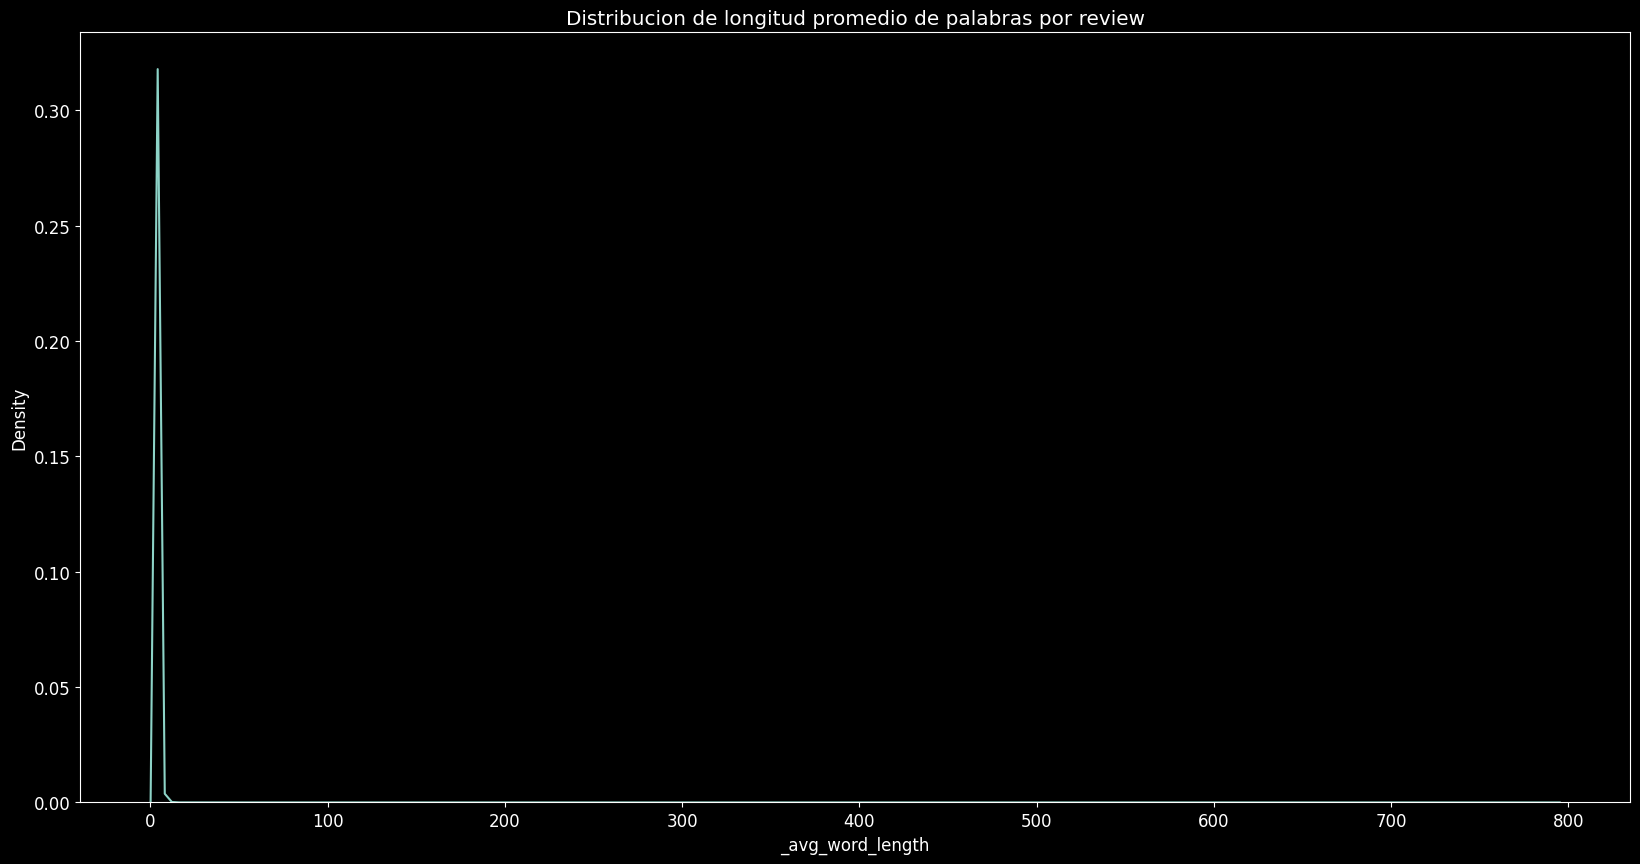

In [35]:
plt.figure(figsize=(20, 10))
avg_word_length = features_vect['_avg_word_length'].to_pandas()
sns.distplot(a=avg_word_length, hist=False)
plt.title('Distribucion de longitud promedio de palabras por review')

>**Conclusión:** tenemos en este caso una distribucion bastante simetrica, alterada levemente por algunos valores muy altos. Se limitó el dominio a 20 para poder visualizar mejor la distribucion

**Analicemos ahora cuales son las expresiones compuestas por dos palabras mas utilizadas**

[Text(0.5, 1.0, 'Top expresiones mas usadas en las reviews')]

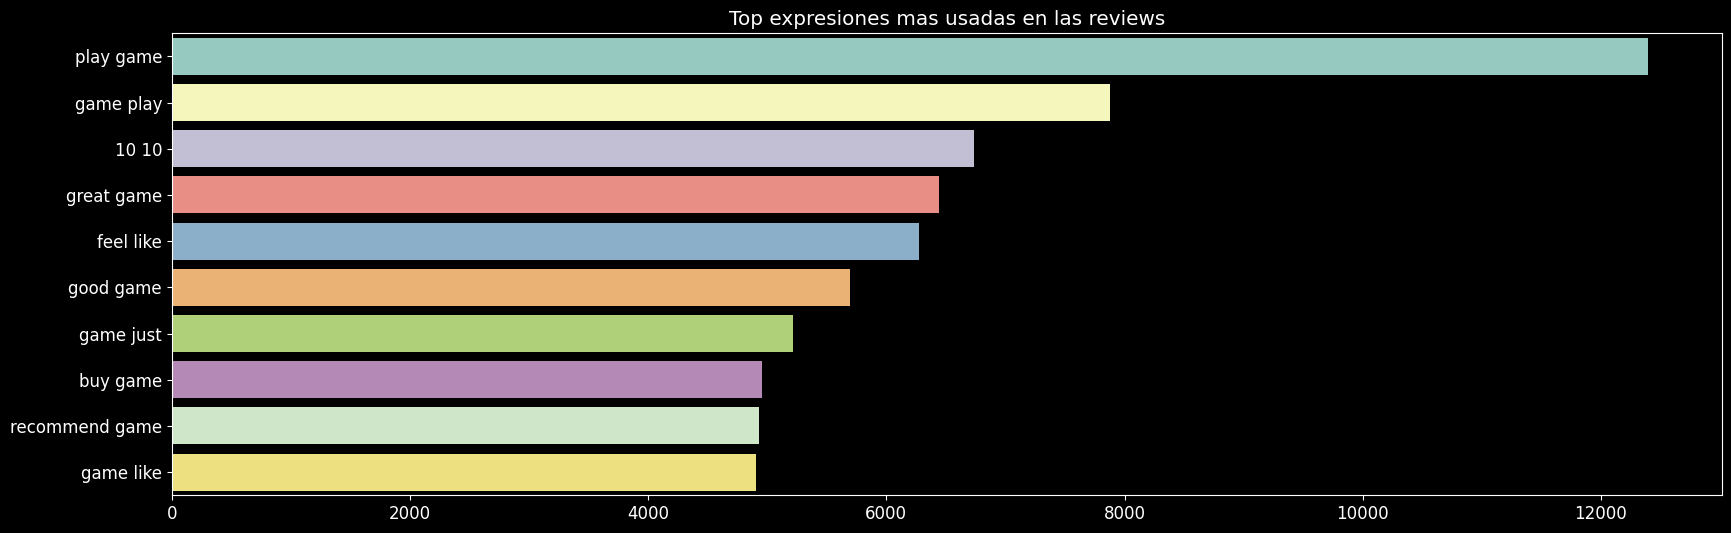

In [40]:
review_text_pd = df.review_text.to_pandas()
vec = CountVectorizer(ngram_range=(2, 2)).fit(review_text_pd)
bag_of_words = vec.transform(review_text_pd)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
x,y=map(list,zip(*words_freq)) 
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x).set(title='Top expresiones mas usadas en las reviews')

>Veamos ahora que pasa separando en reviews positivas y negativas

>**Reviews positivas**

[Text(0.5, 1.0, 'Top expresiones mas usadas en las reviews POSITIVAS sacando stop words')]

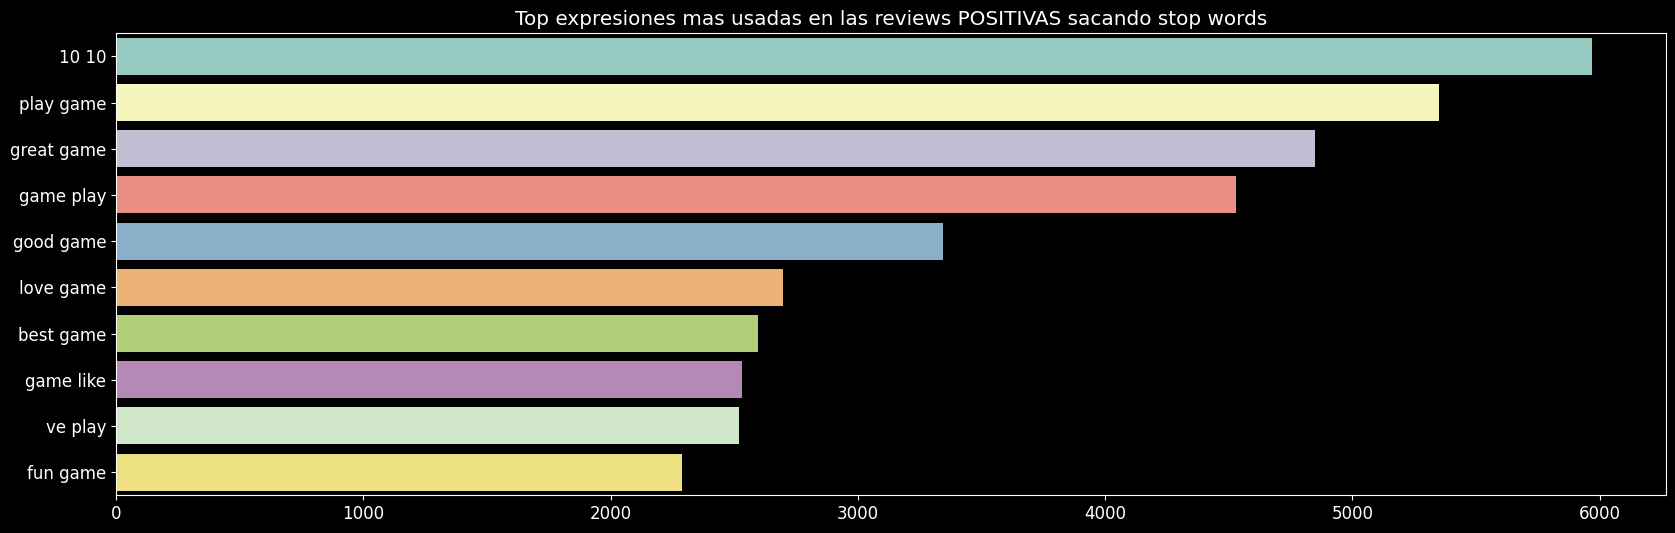

In [43]:
vec = CountVectorizer(ngram_range=(2, 2), stop_words=ENGLISH_STOP_WORDS).fit(df[df['review_score'] == 1].review_text.values_host)
bag_of_words = vec.transform(df[df['review_score'] == 1].review_text.values_host)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) 
              for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
x,y=map(list,zip(*words_freq)) 
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x).set(title='Top expresiones mas usadas en las reviews POSITIVAS sacando stop words')

>**Conclusión:** Se observa un predominio de la expresion 10 10 que viene del uso en las reviews 10/10 que al hacer la limpieza del texto se elimina el slash

>**Reviews negativas** <br>


[Text(0.5, 1.0, 'Top expresiones mas usadas en las reviews NEGATIVAS sacando stop words')]

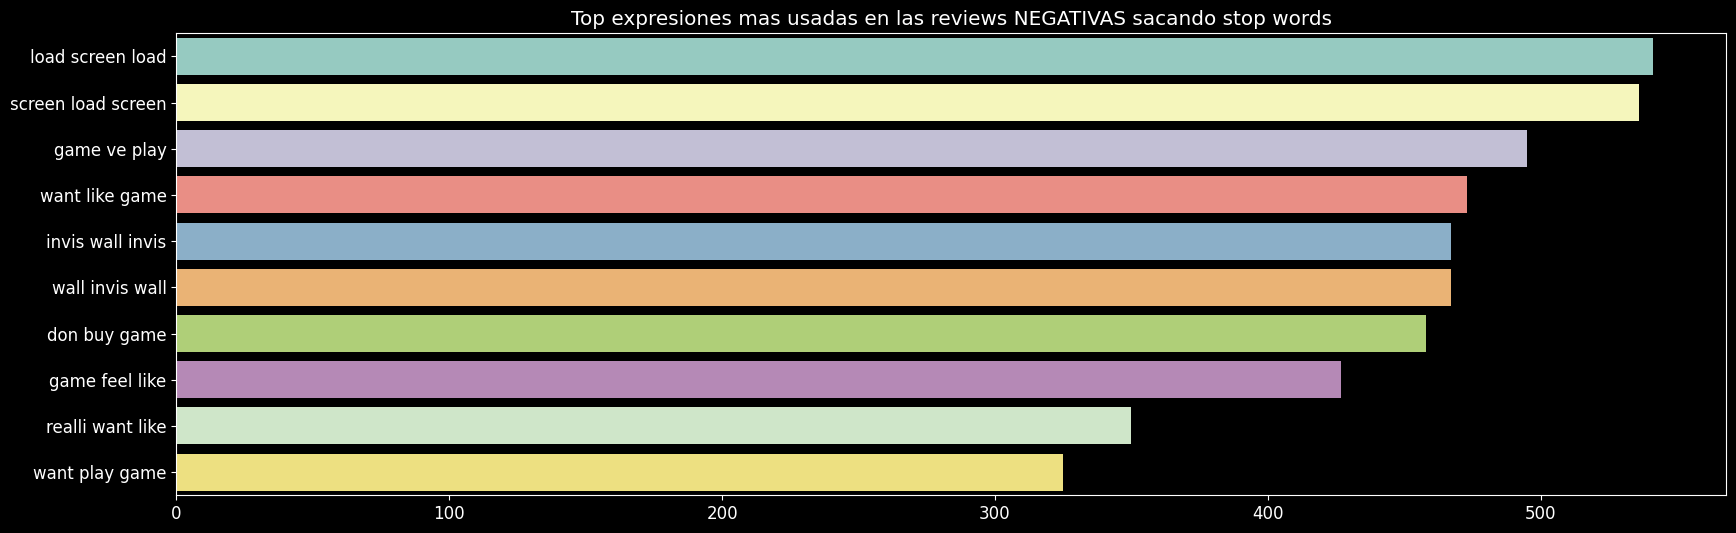

In [44]:
vec = CountVectorizer(ngram_range=(3, 3), max_features=2000).fit(df[df['review_score'] == -1].review_text.values_host)
bag_of_words = vec.transform(df[df['review_score'] == -1].review_text.values_host)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
x,y=map(list,zip(*words_freq)) 
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x).set(title='Top expresiones mas usadas en las reviews NEGATIVAS sacando stop words')

>**Conclusión:** En este caso se decidio usar 3 palabras porque con 2 palabras, por ejemplo, el conjunto "don buy game" quedaba como "buy game" lo que da a entender una expresion positiva, lo que da a entender la importancia de la contextualización. Los 3 primeros valores pueden estar asociados a reviews en las que se repitió muchas veces esas palabras 



> Dropeamos la review que tiene solo "load screeen load screen..." para ver como se modifican los resultados



In [45]:
df = df.drop(df[df['review_text'].str.contains("screen load screen load screen")].index)

[Text(0.5, 1.0, 'Top expresiones mas usadas en las reviews NEGATIVAS sacando stop words')]

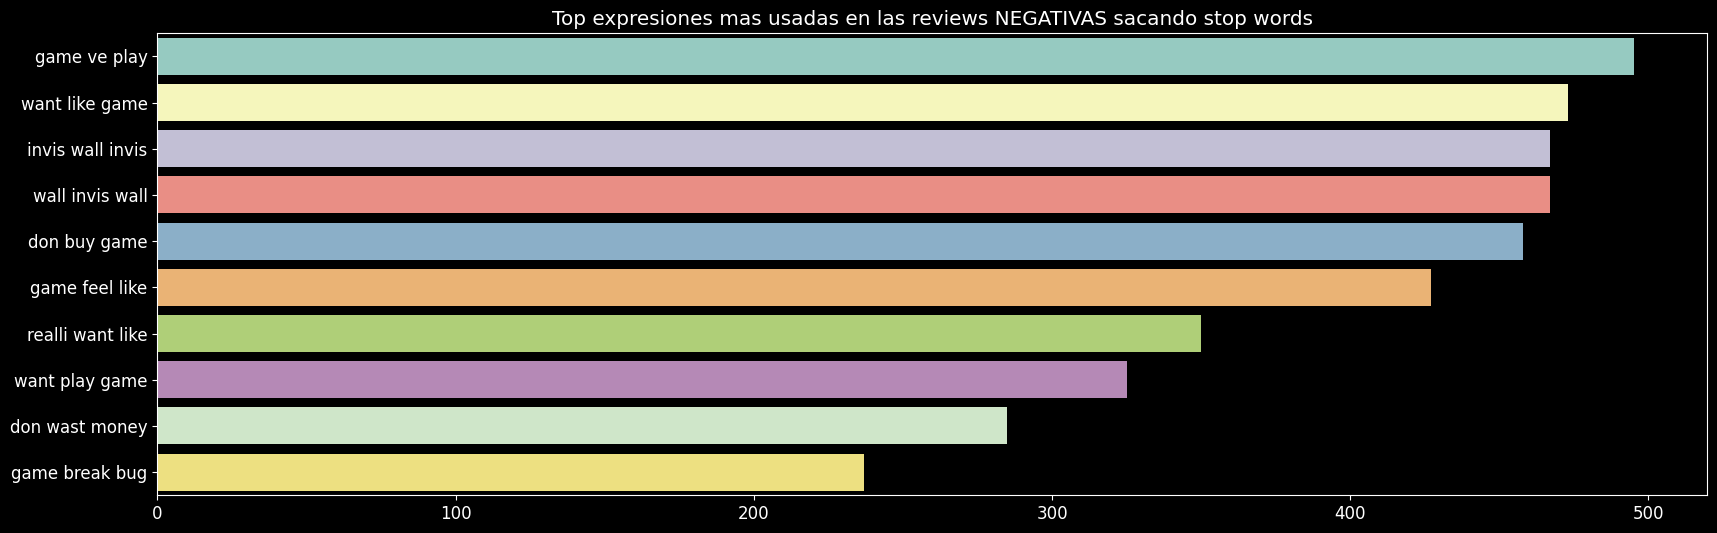

In [46]:
vec = CountVectorizer(ngram_range=(3, 3), max_features=2000).fit(df[df['review_score'] == -1].review_text.values_host)
bag_of_words = vec.transform(df[df['review_score'] == -1].review_text.values_host)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
x,y=map(list,zip(*words_freq)) 
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x).set(title='Top expresiones mas usadas en las reviews NEGATIVAS sacando stop words')

**Veamos la relacion entre la cantidad de palabras usadas en la review y el score**

Text(0.5, 1.0, 'Promedio de palabras usadas en reviews positivas o negativas')

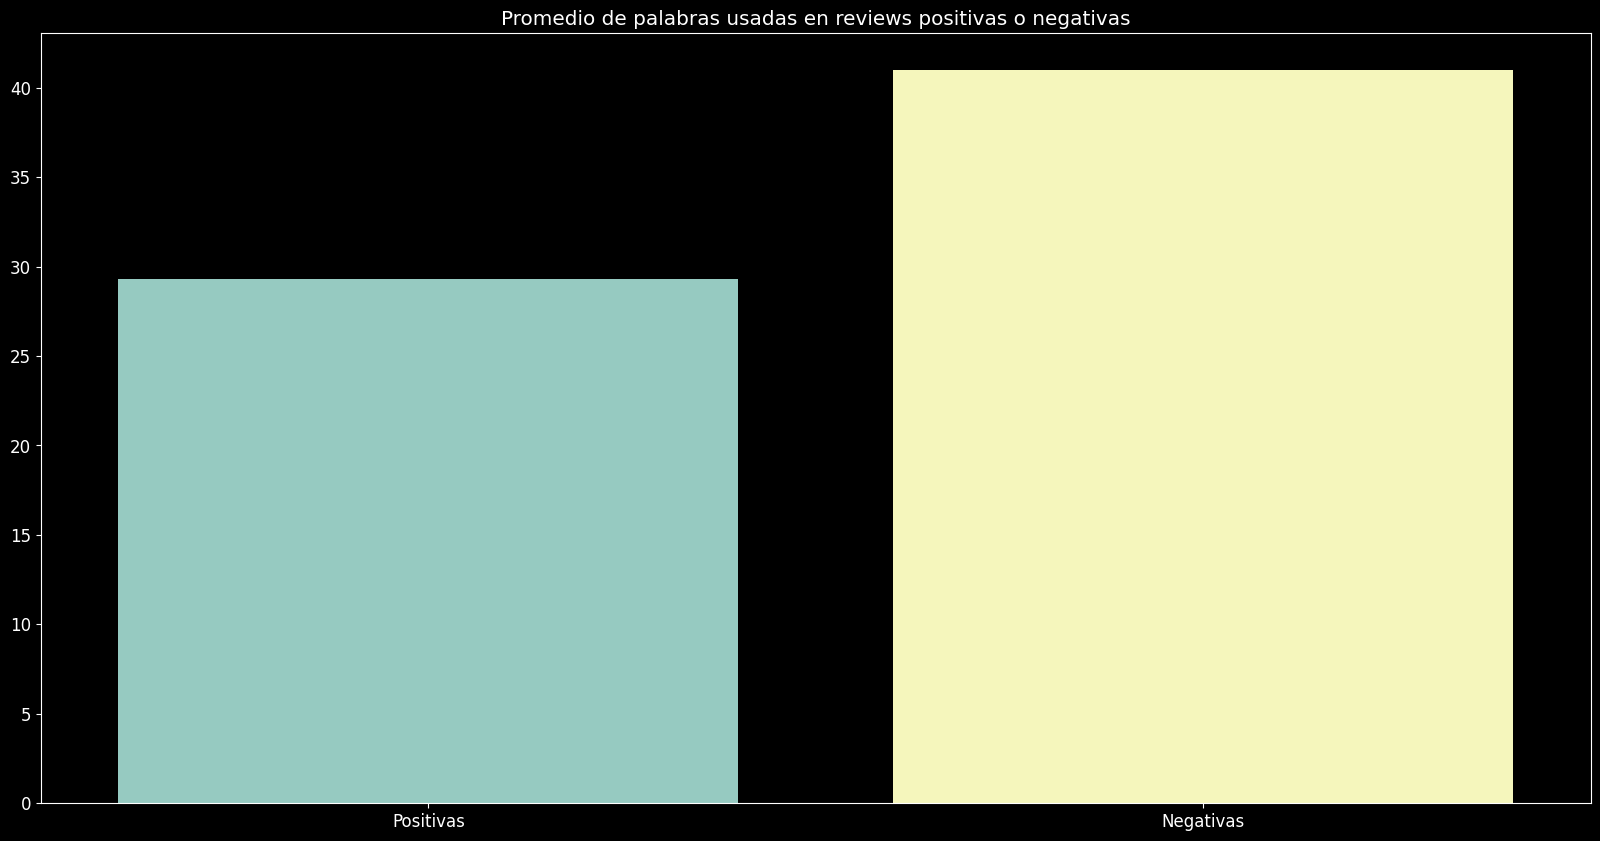

In [47]:
avg_words_pos = features_vect[features_vect['_score'] == 1]['_word_count'].mean()
avg_words_neg = features_vect[features_vect['_score'] == -1]['_word_count'].mean()
plt.figure(figsize = (20, 10))
sns.barplot(x=['Positivas', 'Negativas'], y = [avg_words_pos, avg_words_neg])
plt.title('Promedio de palabras usadas en reviews positivas o negativas')

>**Conclusión:** Se puede observar una clara diferencia en el promedio de cantidad de palabras utilizadas en Reviews Negativas comparandolo con las Positivas. Podriamos inferir que a la hora de escribir una review negativa la gente se explaya de manera contundente para hacer su descargo.

###**Analisis de variables secundarias**

**genre**<br>
Veamos cuales son los 10 generos que mas se repiten

In [48]:
rank_genres = df.drop_duplicates(subset=['app_id']).genres.str.split(';', expand=True).stack().to_frame().reset_index(drop=True).value_counts()
print(f'TOP 10 GENEREOS QUE MAS SE REPITEN EN EL DATASET\n\n{rank_genres[:10]}')

TOP 10 GENEREOS QUE MAS SE REPITEN EN EL DATASET

Indie           3640
Action          2657
Adventure       2153
Casual          1514
Strategy        1339
RPG             1056
Simulation       991
Free to Play     404
Racing           229
Sports           219
dtype: int64


**publisher**<br>
Cuales son las 10 compañias con mas juegos publicados en el dataset

In [49]:
rank_publi = df.drop_duplicates(subset=['app_id']).publisher.str.split(';', expand=True).stack().to_frame().reset_index(drop=True).value_counts()
print(f'TOP 10 COMPAÑIAS CON MAS PUBLICACIONES EN EL DATASET\n\n{rank_publi[:10]}')

TOP 10 COMPAÑIAS CON MAS PUBLICACIONES EN EL DATASET

Ubisoft                83
THQ Nordic             74
Strategy First         72
Square Enix            67
SEGA                   57
1C Entertainment       56
KISS ltd               54
Nightdive Studios      54
Disney Interactive     49
Paradox Interactive    46
dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Ubisoft'),
  Text(1, 0, 'Strategy First'),
  Text(2, 0, 'THQ Nordic'),
  Text(3, 0, 'Square Enix'),
  Text(4, 0, '1C Entertainment'),
  Text(5, 0, 'SEGA'),
  Text(6, 0, 'KISS ltd'),
  Text(7, 0, 'Paradox Interactive'),
  Text(8, 0, 'Degica'),
  Text(9, 0, 'Focus Home Interactive'),
  Text(10, 0, 'Devolver Digital'),
  Text(11, 0, 'Kalypso Media Digital'),
  Text(12, 0, 'Slitherine Ltd.'),
  Text(13, 0, 'United Independent Entertainment GmbH'),
  Text(14, 0, 'Buka Entertainment'),
  Text(15, 0, 'Artifex Mundi'),
  Text(16, 0, 'AGM PLAYISM'),
  Text(17, 0, 'Daedalic Entertainment'),
  Text(18, 0, 'Sekai Project'),
  Text(19, 0, '2K')])

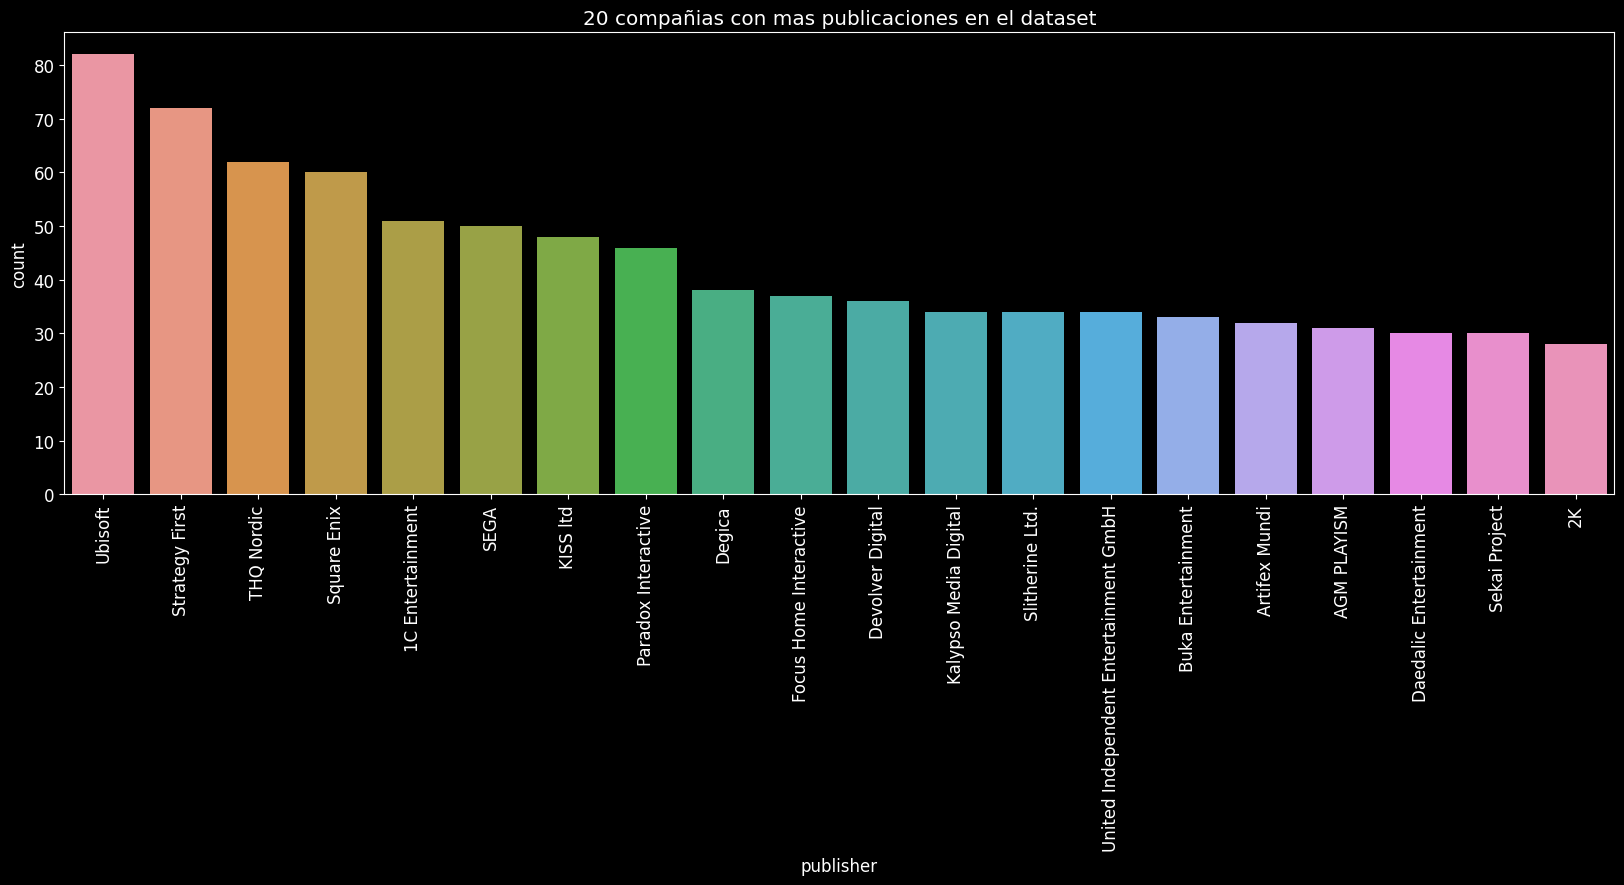

In [52]:
plt.figure(figsize=(20, 6))
publisher = df.drop_duplicates(subset=['app_id']).publisher.to_pandas()
sns.countplot(publisher, order = publisher.value_counts().iloc[:20].index, orient='h')
plt.title('20 compañias con mas publicaciones en el dataset')
plt.xticks(rotation=90)

**Conclusión:** Vemos que grandes compañias como Ubisoft, Strategy First o THQ Nordic son las que mas juegos publica. Lo que no quiere decir que eso sea bueno o mejor para la empresa. Cuando veamos el analisis de las reviews positivas y negativas por empresa veran a que nos referimos.

In [53]:
rank_publi = df.drop_duplicates(subset=['app_id']).developer.str.split(';', expand=True).stack().to_frame().reset_index(drop=True).value_counts()
print(f'TOP 10 COMPAÑIAS CON MAS JUEGOS DESARROLLADOS EN EL DATASET\n\n{rank_publi[:10]}')

TOP 10 COMPAÑIAS CON MAS JUEGOS DESARROLLADOS EN EL DATASET

Feral Interactive (Mac)    33
Valve                      25
Humongous Entertainment    22
Choice of Games            21
Daedalic Entertainment     18
Square Enix                17
Ubisoft Montreal           17
Firaxis Games              16
Aspyr (Mac)                16
MumboJumbo                 15
dtype: int64


**price**<br>
Analizamos como se distribuyen los precios de los juegos.  

Nota: Tener en cuenta que el precio se encuentra en Libras Esterlinas (GBP)

In [54]:
df.drop_duplicates(subset=['app_id']).price.describe().round(2)

count    6031.00
mean        7.19
std         7.05
min         0.00
25%         2.79
50%         5.59
75%         9.99
max        95.99
Name: price, dtype: float64

Text(0.5, 1.0, 'Distribucion de precios')

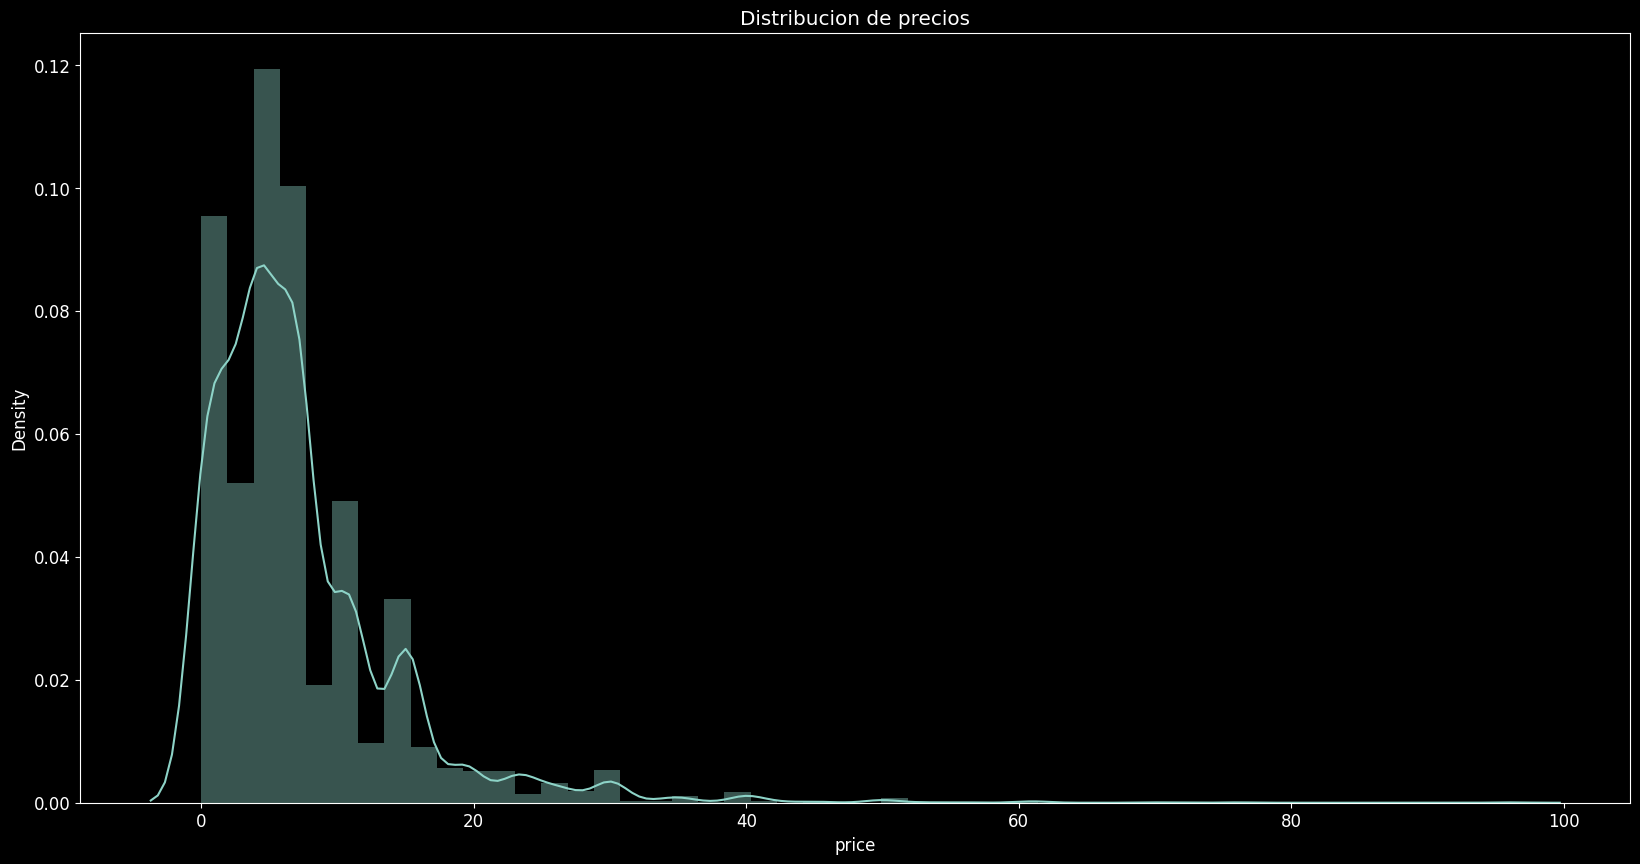

In [56]:
plt.figure(figsize = (20, 10))
sns.distplot(a=df.drop_duplicates(subset=['app_id']).price.to_pandas(), hist=True)
plt.title('Distribucion de precios')

**Conclusión:** Observamos una grafica asimetrica positiva debido a unos pocos juegos con precios excesivamente altos en relacion a la mayor densidad de juegos que van desde ser gratuitos a los 15 o 20 GBP.

**Relacion entre el review_score del juego y publisher**

Con esto buscamos ver la imagen que tienen los usuarios de la empresa publicante.

In [71]:

pandas_df = df.to_pandas()

df_publi_pos = pandas_df[['publisher','review_score']][pandas_df.review_score==1].groupby(['publisher','review_score']).agg(score_count_pos=('review_score','count')).sort_values(by='score_count_pos',ascending=False)
df_publi_neg = pandas_df[['publisher','review_score']][pandas_df.review_score==-1].groupby(['publisher','review_score']).agg(score_count_neg=('review_score','count')).sort_values(by='score_count_neg',ascending=False)
df_publi_merge = df_publi_pos.merge(df_publi_neg,how='inner',on='publisher').head(20)
df_publi_merge['pers_pos'] = round(df_publi_merge.score_count_pos/(df_publi_merge.score_count_pos + df_publi_merge.score_count_neg)*100,2)
df_publi_merge['pers_neg'] = round(df_publi_merge.score_count_neg/(df_publi_merge.score_count_pos + df_publi_merge.score_count_neg)*100,2)
df_publi_merge.head()

KeyError: 'review_score'

In [58]:
df = df_publi_merge

fig = px.scatter(df, x='pers_pos', y='pers_neg', 
           color=df_publi_merge.index, title='Porcentaje de Reviews Score Positivas y Negativas por Empresa Publicante del Juego',
           labels={'pers_neg':'Porcentaje de Reviews Negativas', 'pers_pos':'Porcentaje de Reviews Positivas','publisher':'Empresas' })
fig.show()

NameError: name 'df_publi_merge' is not defined

**Conclusión:** Ahora, haciendo referencia a la conclusion obtenida cuando vimos la cantidad de juegos publicados por empresa, podemos ver claramente como la cantidad de juegos no hace a la calidad de los mismos. Ya que podemos ver como aproximadamente un 60% de los comentarios sobre los juegos de Ubisoft son negativos. Similar ocurre con la empresa Squere Enix, la cual tambien se encuentra entre las 5 empresas con mas juegos publicados, teniendo un 50/50 en relacion a los comentarios.